In [7]:
from transformers.utils import TRANSFORMERS_CACHE
print(TRANSFORMERS_CACHE)

C:\Users\Han\.cache\huggingface\hub


In [9]:
import pandas as pd
import numpy as np
import jieba
import re
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertTokenizer, BertModel
import torch

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

import warnings
warnings.filterwarnings("ignore", message="Torch was not compiled with flash attention")

In [19]:
conts = pd.read_json('../../Data/processed/contents_cooked_semantic.json', lines=True)

# 定义核心关键词
CORE_KEYWORDS = {
    '鲜芋仙', 'Meet Fresh', 'MeetFresh', '台湾美食', '甜品',
    '芋圆', 'taro', '仙草', 'grass jelly', '奶茶', 'milk tea',
    '豆花', 'tofu pudding', '奶刨冰', 'milked shaved ice', 
    '红豆汤', 'purple rice soup', '紫米粥', 'red bean soup',
    '2001 Coit Rd', 'Park Pavillion Center', '(972) 596-6088',
    '刘一手', '锅底', '火锅', '牛奶冰'
}

VERTICAL_DOMAIN_TAGS={'美食', '探店', '火锅', '甜品',
                     '奶茶', '外卖', '中餐', '小吃',
                    'food'}

In [4]:
# =============================================
# 1. MODEL LOADING FUNCTIONS
# =============================================

def load_models():
    """加载所需的各种模型"""
    models = {}
    
    # 原创性检测模型
    models['tfidf'] = TfidfVectorizer(max_features=8000)
    models['simcse'] = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
    
    # 情感分析模型
    models['bert_tokenizer'] = BertTokenizer.from_pretrained("bert-base-chinese")
    models['bert_model'] = BertModel.from_pretrained("bert-base-chinese")
    models['bert_model'].eval()
    
    return models

# =============================================
# 2. PREPROCESSING FUNCTIONS
# =============================================

def preprocess_data(df):
    """数据预处理，创建用户级评分DataFrame"""
    df = df.copy()
    
    # 用户笔记映射
    user_notes = df.groupby('user_id')['semantic_proc_text'].apply(list)
    
    # 创建包含所有用户ID的DataFrame（dim3_score）
    unique_users = df['user_id'].unique()
    dim3_score = pd.DataFrame({'user_id': unique_users, 'score3a_originality': 0
                               , 'score3b_vertical': 0, 'score3c_sentiment': 0
                               , 'score3d_keyword': 0, 'score3_content_quality': 0})
    
    return df, user_notes, dim3_score

In [6]:
# 计算创作者原创性评分
models = load_models()
df, user_notes, dim3_score = preprocess_data(conts)

In [14]:
def calculate_creator_originality(df, dim3_score, models):
    """
    创作者原创性评分计算, 分为内部多样性和外部原创性两个维度
    使用完全不抽样的方式：使用创作者的全部笔记进行计算
    
    1. 内部多样性：使用TF-IDF和SimCSE计算创作者所有笔记之间的相似度
    2. 外部原创性：使用SimCSE计算创作者之间的相似度
    
    Args:
        df (pd.DataFrame): 输入数据框，包含用户笔记和其他信息
        dim3_score (pd.DataFrame): 用户级评分数据框，将被更新
        models (dict): 包含所需模型的字典
    
    Returns:
        pd.DataFrame: 更新后的用户级评分数据框
    """
    print("  - 计算创作者原创性...")
    
    # 按创作者分组准备数据
    user_texts = df.groupby('user_id')['semantic_proc_text'].apply(list).to_dict()
    user_to_indices = {name: group.index.tolist() for name, group in df.groupby('user_id')}
    
    # 存储各项指标
    internal_diversity = {}
    external_originality = {}
    
    # 1. 计算内部多样性（同时使用TF-IDF和SimCSE）
    print("  - 计算创作者内部多样性...")
    for user_id, texts in user_texts.items():
        indices = user_to_indices[user_id]
        
        # 处理笔记数量少的情况
        if len(texts) < 20:  # 少于20篇
            internal_diversity[user_id] = 0.8  # 默认中上多样性分数
            continue
        
        # print(f"用户 {user_id}: 使用全部 {len(texts)} 篇笔记计算内部多样性")
        
        # 使用所有文本 - 不抽样
        all_texts = texts
            
        # 双方法计算多样性
        # 1. TF-IDF计算
        tfidf = models['tfidf'].fit_transform(all_texts)
        tfidf_sim = cosine_similarity(tfidf)
        np.fill_diagonal(tfidf_sim, 0)
        tfidf_avg_sim = np.mean(tfidf_sim)
        
        # 2. SimCSE计算
        embeddings = models['simcse'].encode(all_texts, show_progress_bar=False)
        emb_sim = cosine_similarity(embeddings)
        np.fill_diagonal(emb_sim, 0)
        emb_avg_sim = np.mean(emb_sim)
        
        # 结合两种方法（取平均相似度）
        avg_sim = 0.5 * tfidf_avg_sim + 0.5 * emb_avg_sim
        
        # 转换为内部多样性评分
        internal_diversity[user_id] = 1 - avg_sim
    
    # 2. 计算外部原创性
    print("  - 计算创作者之间的原创性差异...")
    
    # 为每个创作者构建代表性文本集 - 仍使用头部和热门的抽样策略，避免计算过度庞大
    representative_texts = {}
    for user_id in user_texts.keys():
        # 获取该创作者的所有笔记索引
        indices = user_to_indices[user_id]
        
        # 提取头部笔记（最新的10篇）
        top_indices = indices[:min(10, len(indices))]
        
        # 获取热门笔记
        hot_indices = df.loc[indices].query("hot_note == 1").index.tolist()
        if hot_indices and len(hot_indices) > 30:
            import random
            hot_indices = random.sample(hot_indices, 30)  # 最多选30篇热门
        
        # 如果头部+热门笔记总数少于40，补充随机笔记
        if len(top_indices) + len(hot_indices) < 40 and len(indices) > len(top_indices) + len(hot_indices):
            remaining_indices = [i for i in indices if i not in top_indices and i not in hot_indices]
            import random
            random_count = min(40 - len(top_indices) - len(hot_indices), len(remaining_indices))
            random_indices = random.sample(remaining_indices, random_count)
        else:
            random_indices = []
        
        # 合并所有选定的索引
        selected_indices = list(set(top_indices + hot_indices + random_indices))
        
        # 获取对应的文本
        representative_texts[user_id] = df.loc[selected_indices, 'semantic_proc_text'].tolist() if selected_indices else []
    
    # 对代表性文本进行编码
    print("  - 对代表性文本进行语义编码...")
    user_embeddings = {}
    all_rep_texts = []
    user_mapping = []
    
    for user_id, texts in representative_texts.items():
        if not texts:  # 防止空文本列表
            continue
        all_rep_texts.extend(texts)
        user_mapping.extend([user_id] * len(texts))
    
    # 只对代表性文本使用SimCSE
    if all_rep_texts:
        embeddings = models['simcse'].encode(all_rep_texts, show_progress_bar=True)
        
        # 按创作者聚合
        for i, user_id in enumerate(user_mapping):
            if user_id not in user_embeddings:
                user_embeddings[user_id] = []
            user_embeddings[user_id].append(embeddings[i])
    
    # 计算创作者级平均表示
    for user_id, embs in user_embeddings.items():
        if embs:  # 确保有嵌入向量
            user_embeddings[user_id] = np.mean(embs, axis=0)
    
    # 计算创作者间相似度
    user_ids = list(user_embeddings.keys())
    
    for i, user_id in enumerate(user_ids):
        user_emb = user_embeddings[user_id]
        similarities = []
        
        for j, other_id in enumerate(user_ids):
            if i != j:
                other_emb = user_embeddings[other_id]
                sim = cosine_similarity([user_emb], [other_emb])[0][0]
                similarities.append(sim)
        
        # 外部原创性
        if similarities:
            # 不仅考虑平均相似度，也考虑最大相似度（最大相似度权重更高）
            avg_sim = np.mean(similarities)
            max_sim = np.max(similarities)
            weighted_sim = 0.6 * avg_sim + 0.4 * max_sim
            external_originality[user_id] = 1 - weighted_sim
        else:
            external_originality[user_id] = 0.9  # 默认高的原创性
    
    # 3. 结合两个维度并应用分数映射
    print("  - 组合评分并应用分布校正...")
    user_originality = {}
    
    for user_id in user_texts.keys():
        int_div = internal_diversity.get(user_id, 0.5)
        ext_orig = external_originality.get(user_id, 0.5)
        
        # 组合分数
        combined_raw = 0.5 * int_div + 0.5 * ext_orig
        
        # Sigmoid映射到0-25区间
        user_originality[user_id] = 25 / (1 + np.exp(-8 * (combined_raw - 0.5)))
    
    # 分布校正
    scores = np.array(list(user_originality.values()))
    mean = np.mean(scores)
    std = np.std(scores)
    
    if std < 4:  # 分布过于集中
        # 双边拉伸但保持相对关系
        stretch_factor = 5 / std if std > 0 else 1.5
        for user_id in user_originality:
            diff = user_originality[user_id] - mean
            user_originality[user_id] = np.clip(mean + diff * stretch_factor, 0, 25)
            
            # 软化极端值
            if user_originality[user_id] > 23:
                user_originality[user_id] = 23 + (user_originality[user_id] - 23) * 0.5
            elif user_originality[user_id] < 2:
                user_originality[user_id] = 2 * (user_originality[user_id] / 2)
    
    # 直接更新dim3_score的score3a_originality列
    for user_id, score in user_originality.items():
        idx = dim3_score[dim3_score['user_id'] == user_id].index
        if len(idx) > 0:
            dim3_score.loc[idx, 'score3a_originality'] = score
    
    return dim3_score

In [15]:
# 获取创作者维度的原创性评分
dim3_score = calculate_creator_originality(df, dim3_score, models)

  - 计算创作者原创性...
  - 计算创作者内部多样性...
  - 计算创作者之间的原创性差异...
  - 对代表性文本进行语义编码...


Batches:   0%|          | 0/122 [00:00<?, ?it/s]

  - 组合评分并应用分布校正...


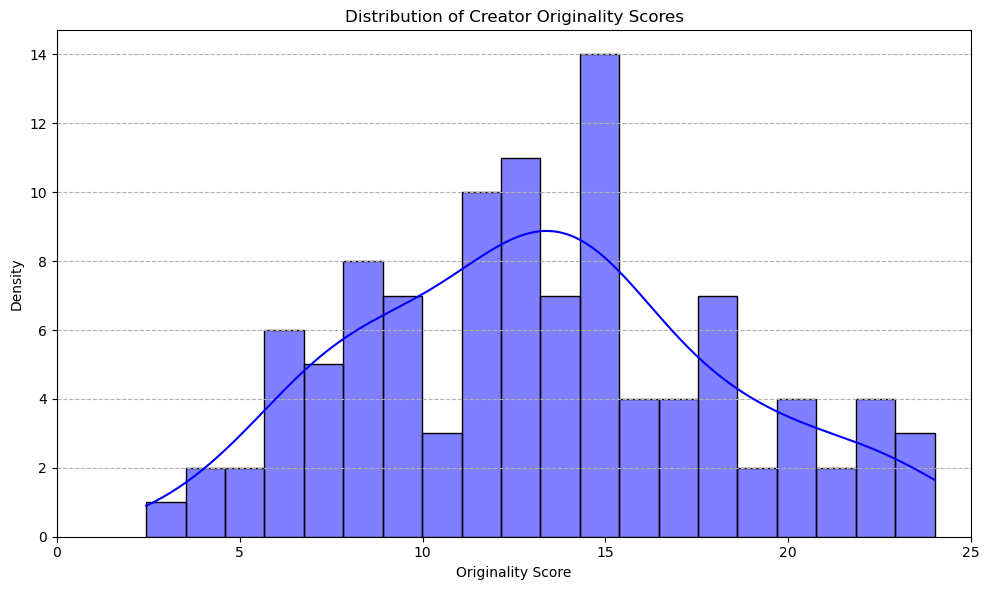

count    106.000000
mean      13.244688
std        4.911721
min        2.440105
25%        9.255538
50%       12.959826
75%       15.728577
max       24.000000
Name: score3a_originality, dtype: float64

In [ ]:
# plot the histogram of dim3_score
plt.figure(figsize=(10, 6))
sns.histplot(dim3_score['score3a_originality'], bins=20, kde=True, color='blue', stat='count')
plt.title('Distribution of Creator Originality Scores')
plt.xlabel('Originality Score')
plt.ylabel('Density')
plt.xlim(0, 25)
plt.xticks(np.arange(0, 26, 5))
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('../../Data/processed/dim3_score_distribution.png')
plt.show()

# get the statistics of dim3_score.score3a_originality
dim3_score['score3a_originality'].describe()

In [33]:
def calculate_vertical_score(df, dim3_score, target_tags=VERTICAL_DOMAIN_TAGS):
    """
    计算垂直领域得分
    基于创作者笔记中包含目标标签子字符串的比例，使用Sigmoid映射
    
    Args:
        df (pd.DataFrame): 输入数据框，包含笔记信息
        dim3_score (pd.DataFrame): 用户级评分数据框，将被更新
        target_tags (set): 目标标签集合
    
    Returns:
        pd.DataFrame: 更新后的用户级评分数据框
    """
    print(f"  - 计算垂直领域分数... (目标标签: {target_tags})")
    
    # 检查每个笔记的标签列表是否包含任何目标标签作为子字符串
    def has_target_tag(tags):
        if not tags or pd.isna(tags):
            return 0
        
        # 将用户标签拆分为列表
        user_tags = str(tags).split(',')
        
        # 检查每个用户标签是否包含任何目标标签作为子字符串
        for user_tag in user_tags:
            user_tag = user_tag.strip().lower()  # 移除前后空格并转为小写
            for target_tag in target_tags:
                target_tag = str(target_tag).lower()  # 转为小写以进行不区分大小写的比较
                if target_tag in user_tag:  # 如果目标标签是用户标签的子字符串
                    return 1
                    
        return 0
    
    # 添加标记列
    df['has_target_tag'] = df['tag_list'].apply(has_target_tag)
    
    # 按创作者分组计算包含目标标签的笔记比例
    user_vertical_scores = {}
    raw_ratios = {}  # 存储原始比例，用于诊断
    
    for user_id, group in df.groupby('user_id'):
        # 计算包含目标标签的笔记比例
        target_tag_ratio = group['has_target_tag'].mean()
        raw_ratios[user_id] = target_tag_ratio  # 保存原始比例
        
        # 输出调试信息
        # print(f"用户 {user_id}: {len(group)} 篇笔记, {target_tag_ratio:.1%} 包含目标标签")
        
        # 使用幂函数提升低比例的得分 - 保留这一步
        adjusted_ratio = target_tag_ratio ** 0.7  # 使用0.7次幂拉伸低分区间
        
        # 直接使用Sigmoid函数进行映射 - 参数调整使分布更均匀
        # 将slope从8调整为5，使曲线更陡峭，分布更分散
        slope = 5.0  # 控制曲线陡峭程度
        midpoint = 0.5  # 中心点，调整为0.4使整体分数偏高些
        
        # Sigmoid映射到0-25区间
        sigmoid_score = 25 / (1 + np.exp(-slope * (adjusted_ratio - midpoint)))
        
        # 存储sigmoid转换后的分数
        user_vertical_scores[user_id] = sigmoid_score
    
    # 输出原始分数统计
    scores = np.array(list(user_vertical_scores.values()))
    mean = np.mean(scores)
    std = np.std(scores)
    
    print(f"  - Sigmoid转换后分数: 均值={mean:.2f}, 标准差={std:.2f}")
    
    # 特殊处理: 将0覆盖率用户设为0分
    for user_id, ratio in raw_ratios.items():
        if ratio == 0:
            user_vertical_scores[user_id] = 0
    
    # 处理极端情况: 防止极高或极低分过多
    high_scores = sum(1 for s in scores if s > 23)
    low_scores = sum(1 for s in scores if s > 0 and s < 2)
    
    # 如果高分或低分过多，微调分布
    if high_scores > len(scores) * 0.15 or low_scores > len(scores) * 0.15:
        print("  - 检测到极端分数过多，应用轻微分布校正...")
        
        for user_id in user_vertical_scores:
            score = user_vertical_scores[user_id]
            # 仅对非零分进行处理
            if score > 0:
                # 软化高分
                if score > 23:
                    user_vertical_scores[user_id] = 23 + (score - 23) * 0.5
                # 提升低分
                elif score < 2:
                    user_vertical_scores[user_id] = 2 * (score / 2)
    
    # 最终分数统计
    corrected_scores = np.array(list(user_vertical_scores.values()))
    corrected_mean = np.mean(corrected_scores)
    corrected_std = np.std(corrected_scores)
    print(f"  - 最终垂直领域分数: 均值={corrected_mean:.2f}, 标准差={corrected_std:.2f}")
    
    # 输出分布情况
    bins = [0, 5, 10, 15, 20, 25]
    hist, _ = np.histogram(corrected_scores, bins=bins)
    print("  - 分数分布:")
    for i in range(len(bins)-1):
        print(f"    {bins[i]}-{bins[i+1]}: {hist[i]} 人")
    
    # 更新dim3_score的score3b_vertical列
    for user_id, score in user_vertical_scores.items():
        idx = dim3_score[dim3_score['user_id'] == user_id].index
        if len(idx) > 0:
            dim3_score.loc[idx, 'score3b_vertical'] = score
    
    # 移除临时列
    if 'has_target_tag' in df.columns:
        df.drop(columns=['has_target_tag'], inplace=True)
    
    return dim3_score

In [34]:
# 获取创作者维度的垂直领域评分
dim3_score = calculate_vertical_score(df, dim3_score)

  - 计算垂直领域分数... (目标标签: {'奶茶', '美食', '小吃', '外卖', 'food', '火锅', '甜品', '中餐', '探店'})
  - Sigmoid转换后分数: 均值=9.60, 标准差=6.26
  - 最终垂直领域分数: 均值=9.47, 标准差=6.43
  - 分数分布:
    0-5: 35 人
    5-10: 26 人
    10-15: 17 人
    15-20: 22 人
    20-25: 6 人


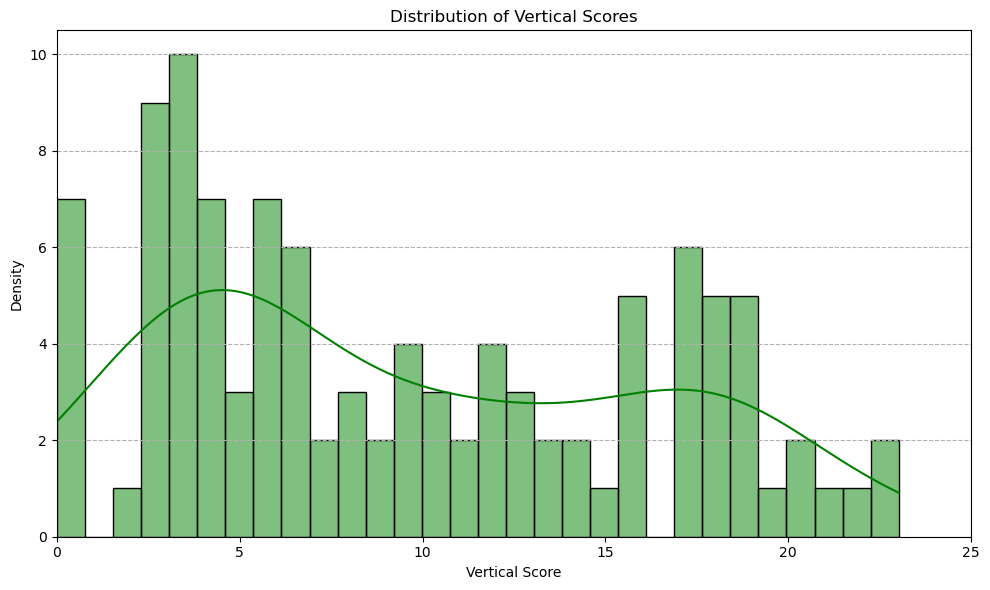

count    106.000000
mean       9.470925
std        6.464829
min        0.000000
25%        3.897946
50%        7.960763
75%       15.702387
max       23.019377
Name: score3b_vertical, dtype: float64

In [35]:
# plot the histogram of dim3_score.vertical_score
plt.figure(figsize=(10, 6))
sns.histplot(dim3_score['score3b_vertical'], bins=30, kde=True, color='green', stat='count')
plt.title('Distribution of Vertical Scores')
plt.xlabel('Vertical Score')
plt.ylabel('Density')
plt.xlim(0, 25)
plt.xticks(np.arange(0, 26, 5))
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('../../Data/processed/dim3_vertical_score_distribution.png')
plt.show()

# get the statistics of dim3_score.vertical_score
dim3_score['score3b_vertical'].describe()

In [103]:
def calculate_sentiment_score(df, dim3_score, models, max_notes_per_user=60):
    """
    计算情感强度得分，整合BERT情感分析、时间衰减和分布校正
    - 每个创作者最多只处理指定数量的笔记（默认60篇）
    - 优先选择最新的10篇笔记和所有热门笔记
    - 如果不足指定上限，添加更多最新笔记
    - 当max_notes_per_user=1000时，使用全部笔记
    
    Args:
        df (pd.DataFrame): 输入数据框，包含用户笔记
        dim3_score (pd.DataFrame): 用户级评分数据框，将被更新
        models (dict): 包含所需模型的字典
        max_notes_per_user (int): 每个用户最多处理的笔记数量，默认60，设为1000时使用全部笔记
        
    Returns:
        pd.DataFrame: 更新后的用户级评分数据框
    """
    print("  - 计算情感强度得分...")
    print(f"  - 每个用户最多处理 {max_notes_per_user} 篇笔记...")
    
    # 内部函数：使用BERT计算单个笔记的情感值
    def get_bert_sentiment(text, tokenizer, model):
        """使用BERT计算单个笔记的情感值"""
        if not text or not isinstance(text, str):
            return 0.0
            
        try:
            # 截断长文本以提高性能
            text = text[:512]
            inputs = tokenizer(text, return_tensors="pt", truncation=True)
            with torch.no_grad():
                outputs = model(**inputs)
            return outputs.last_hidden_state.mean().item()
        except Exception as e:
            print(f"  - 警告: 情感计算出错: {str(e)[:100]}...")
            return 0.0
    
    # 1. 为每个创作者选择要计算的笔记
    print("  - 为每位创作者选择笔记...")
    user_selected_indices = {}
    
    for user_id, group in df.groupby('user_id'):
        # 按时间排序 - 确保索引是从新到旧排列的
        group = group.sort_values('elapsed_time', ascending=True)
        indices = group.index.tolist()
        
        # 检查是否使用全部笔记
        use_all_notes = (max_notes_per_user >= 1000)
        
        if use_all_notes:
            # 使用全部笔记
            selected_indices = indices
            print(f"用户 {user_id}: 使用全部 {len(selected_indices)} 篇笔记进行情感分析")
        else:
            # 选择最新的10篇笔记
            top_indices = indices[:min(10, len(indices))]
            
            # 选择所有热门笔记
            hot_indices = group[group['hot_note'] == 1].index.tolist()
            
            # 合并并去重
            selected_indices = list(set(top_indices + hot_indices))
            
            # 如果不足指定上限，添加更多最新笔记
            if len(selected_indices) < max_notes_per_user and len(indices) > len(selected_indices):
                # 找出尚未选择的最新笔记
                remaining_indices = [i for i in indices if i not in selected_indices]
                # 取足够的笔记以达到上限或用完所有笔记
                additional_count = min(max_notes_per_user - len(selected_indices), len(remaining_indices))
                additional_indices = remaining_indices[:additional_count]
                # 合并所有选定的索引
                selected_indices = list(set(selected_indices + additional_indices))
            
            print(f"用户 {user_id}: 选择了 {len(selected_indices)} 篇笔记进行情感分析 (上限: {max_notes_per_user})")
        
        # 存储选定的索引
        user_selected_indices[user_id] = selected_indices
    
    # 2. 只对选定的笔记计算情感值
    print("  - 计算选定笔记的情感值...")
    # 创建一个映射来存储计算过的情感值
    sentiment_values = {}
    
    # 使用较小的样本估算平均处理时间
    sample_size = min(50, len(df))
    sample_df = df.sample(n=sample_size) if len(df) > sample_size else df
    
    # 估算处理时间
    import time
    start = time.time()
    sample_sentiments = [get_bert_sentiment(text, models['bert_tokenizer'], models['bert_model']) 
                          for text in sample_df['semantic_proc_text'].values[:5]]
    elapsed = time.time() - start
    
    # 输出一些样本值进行诊断
    print(f"  - 样本情感值: {[round(s, 4) for s in sample_sentiments[:5]]}")
    
    # 计算选定笔记的总数，用于估计总处理时间
    total_selected_notes = sum(len(indices) for indices in user_selected_indices.values())
    est_total_time = elapsed * total_selected_notes / 5 / 60  # 分钟
    print(f"  - 估计情感分析总耗时: {est_total_time:.1f}分钟 (处理 {total_selected_notes} 篇笔记)")
    
    # 为每个用户处理选定的笔记
    for user_id, indices in user_selected_indices.items():
        for idx in indices:
            text = df.loc[idx, 'semantic_proc_text']
            sentiment_values[idx] = get_bert_sentiment(text, models['bert_tokenizer'], models['bert_model'])
    
    # 将情感值添加到DataFrame，未计算的设为0
    df['sentiment_raw'] = pd.Series(sentiment_values).reindex(df.index).fillna(0.0)
    
    # 打印情感值统计信息，帮助诊断
    print(f"  - 情感原始值统计: {df['sentiment_raw'].describe()}")
    
    # 3. 应用时间衰减系数
    print("  - 应用时间衰减...")
    decay = np.exp(-0.05 * df['elapsed_time'] / 7)  # 一周衰减约30%
    df['sentiment'] = df['sentiment_raw'] * decay
    
    # 4. 按用户聚合情感分数
    print("  - 聚合用户级情感分数...")
    user_sentiment_scores = {}
    
    # 使用绝对值处理情感分数 - 同时保留一部分极性
    df['sentiment_abs'] = df['sentiment'].abs()
    
    for user_id, indices in user_selected_indices.items():
        # 只使用选定的笔记计算情感得分
        selected_df = df.loc[indices]
        
        # 取用户笔记的情感均值（考虑时间衰减后）
        sentiment_mean = selected_df['sentiment'].mean() 
        sentiment_abs_mean = selected_df['sentiment_abs'].mean()
        
        # 计算情感强度分数 - 使用绝对值均值*40作为基础映射
        intensity_score = min(20, sentiment_abs_mean * 40)
        
        # 考虑情感极性 - 负面情感适当降低分数
        polarity_factor = 1.0
        if sentiment_mean < 0:
            polarity_factor = 0.9  # 轻微降低负面情感分数
        
        # 综合计算最终分数
        raw_score = intensity_score * polarity_factor
        
        # 确保最低分为1分
        user_sentiment_scores[user_id] = max(1.0, raw_score)
    
    # 5. 应用分数分布校正
    print("  - 校正情感分数分布...")
    scores = np.array(list(user_sentiment_scores.values()))
    mean = np.mean(scores)
    std = np.std(scores)
    
    print(f"  - 原始情感分数: 均值={mean:.2f}, 标准差={std:.2f}")
    
    # 双边拉伸 - 使用较大的拉伸因子
    target_std = 6.0  # 目标标准差
    if std < target_std and std > 0:
        stretch_factor = target_std / std
        for user_id in user_sentiment_scores:
            diff = user_sentiment_scores[user_id] - mean
            stretched_score = mean + diff * stretch_factor
            user_sentiment_scores[user_id] = np.clip(stretched_score, 1.0, 25.0)
    
    # 提升均值到理想范围 - 如果均值过低
    scores = np.array(list(user_sentiment_scores.values()))
    mean = np.mean(scores)
    
    if mean < 12:  # 如果均值低于12，进行适当提升
        boost = 12 - mean
        for user_id in user_sentiment_scores:
            user_sentiment_scores[user_id] = min(25.0, user_sentiment_scores[user_id] + boost)
    
    # 校正后的统计
    corrected_scores = np.array(list(user_sentiment_scores.values()))
    corrected_mean = np.mean(corrected_scores)
    corrected_std = np.std(corrected_scores)
    print(f"  - 校正后情感分数: 均值={corrected_mean:.2f}, 标准差={corrected_std:.2f}")
    
    # 6. 更新dim3_score的sentiment_score列
    for user_id, score in user_sentiment_scores.items():
        idx = dim3_score[dim3_score['user_id'] == user_id].index
        if len(idx) > 0:
            dim3_score.loc[idx, 'sentiment_score'] = score
    
    # 7. 清理中间数据
    for col in ['sentiment_raw', 'sentiment', 'sentiment_abs']:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)
    
    return dim3_score

  - 计算情感强度得分...
  - 每个用户最多处理 50 篇笔记...
  - 为每位创作者选择笔记...
用户 54d82c482e1d9366ebfc8ce5: 选择了 50 篇笔记进行情感分析 (上限: 50)
用户 5530f8642e1d9365fa9a29fb: 选择了 50 篇笔记进行情感分析 (上限: 50)
用户 55481451b203d97e86008c02: 选择了 50 篇笔记进行情感分析 (上限: 50)
用户 556f1983f5a26347140b104b: 选择了 50 篇笔记进行情感分析 (上限: 50)
用户 558a4a065894460336de85bf: 选择了 60 篇笔记进行情感分析 (上限: 50)
用户 55f2f7e3f5a2635bd2fac7b5: 选择了 50 篇笔记进行情感分析 (上限: 50)
用户 5649379603eb842b7ed00477: 选择了 50 篇笔记进行情感分析 (上限: 50)
用户 564d4a9167bc65539cd768d4: 选择了 50 篇笔记进行情感分析 (上限: 50)
用户 568b2f486a6a6962f22d07ba: 选择了 50 篇笔记进行情感分析 (上限: 50)
用户 56ada7e482ec39541becb6ff: 选择了 50 篇笔记进行情感分析 (上限: 50)
用户 56b2e6dae4251d7f46ab14e3: 选择了 50 篇笔记进行情感分析 (上限: 50)
用户 570b4b5a1c07df4cfd6ccbf0: 选择了 50 篇笔记进行情感分析 (上限: 50)
用户 576d3bde82ec3952ff40c5e1: 选择了 50 篇笔记进行情感分析 (上限: 50)
用户 576e5cc95e87e72f9801db4d: 选择了 33 篇笔记进行情感分析 (上限: 50)
用户 57a142546a6a695a454d664e: 选择了 50 篇笔记进行情感分析 (上限: 50)
用户 57edc02550c4b47c9e876daf: 选择了 50 篇笔记进行情感分析 (上限: 50)
用户 57f5f8b06a6a6963e65ffc89: 选择了 50 篇笔记进行情感分析 (上限: 50)
用户 57fda

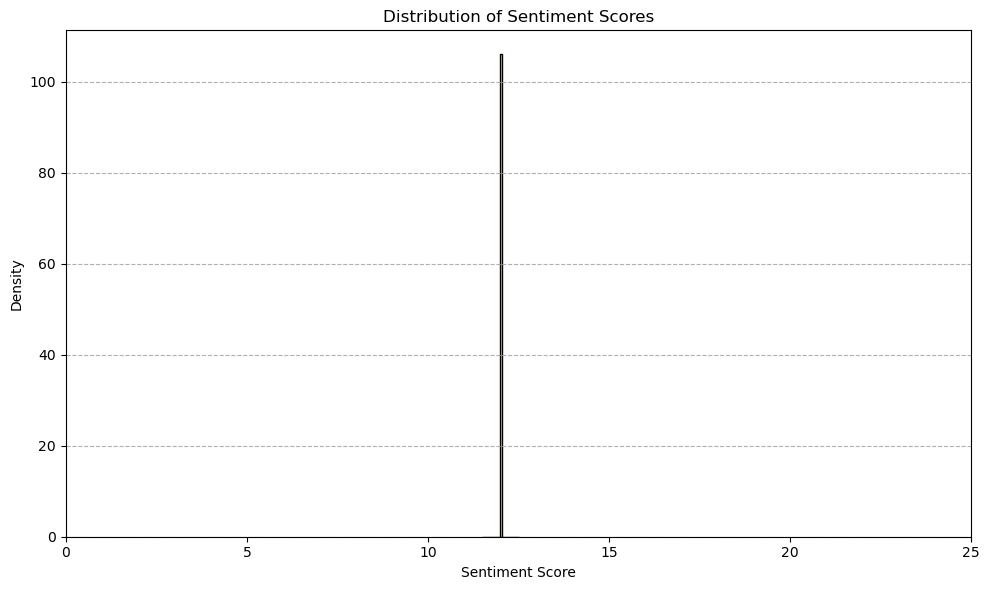

count    106.0
mean      12.0
std        0.0
min       12.0
25%       12.0
50%       12.0
75%       12.0
max       12.0
Name: sentiment_score, dtype: float64

In [ ]:
# 获取创作者维度的情感评分
dim3_score = calculate_sentiment_score(df, dim3_score, models, max_notes_per_user=50)

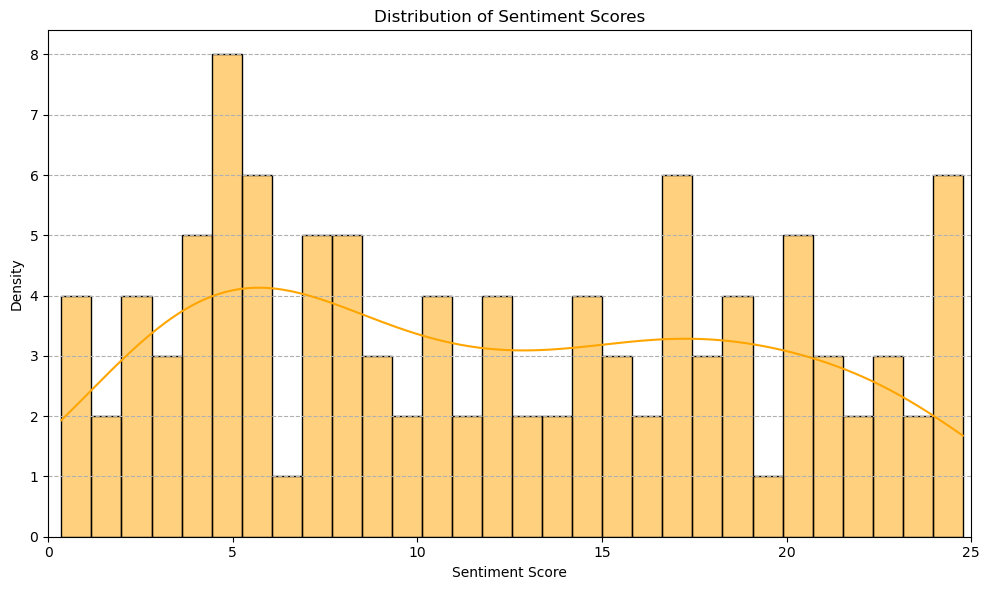

count    106.000000
mean      11.949209
std        7.212734
min        0.358313
25%        5.384707
50%       11.352009
75%       17.767863
max       24.776204
Name: sentiment_score, dtype: float64

In [109]:
# plot the histogram of dim3_score.sentiment_score
plt.figure(figsize=(10, 6))
sns.histplot(dim3_score['sentiment_score'], bins=30, kde=True, color='orange', stat='count')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.xlim(0, 25)
plt.xticks(np.arange(0, 26, 5))
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('../../Data/processed/dim3_sentiment_score_distribution.png')
plt.show()

# get the statistics of dim3_score.sentiment_score
dim3_score['sentiment_score'].describe()

In [53]:
def calculate_keyword_score(df, dim3_score, core_keywords):
    """
    计算关键词覆盖得分 - Sigmoid增强版
    1. 支持子字符串匹配
    2. 使用增强型Sigmoid函数映射，确保分数充分利用0-25范围
    3. 应用更激进的参数调整
    
   Args:
    df (pd.DataFrame): 输入数据框，包含笔记信息
    dim3_score (pd.DataFrame): 用户级评分数据框，将被更新
    core_keywords (set): 核心关键词集合
    
    Returns:
        pd.DataFrame: 更新后的用户级评分数据框
    """
    print("  - 计算关键词覆盖得分...")

    # 1. 创建高效的关键词匹配模式 (预编译一次)
    print("  - 创建关键词匹配模式...")
    pattern = re.compile('|'.join(re.escape(kw) for kw in core_keywords), 
                        flags=re.IGNORECASE)

    # 2. 计算关键词数量
    print("  - 计算笔记级关键词覆盖...")
    df['kw_count'] = df['semantic_proc_text'].fillna("").apply(
        lambda x: len(pattern.findall(str(x)))
    )

    # 3. 应用时间衰减系数
    print("  - 应用时间衰减系数...")
    decay = np.exp(-0.05 * df['elapsed_time'] / 7)

    # 4. 计算单篇得分
    df['single_kw_score'] = np.maximum(1, df['kw_count'] / 5) * decay

    # 5. 按创作者聚合关键词得分 - 不使用90%分位数
    print("  - 聚合用户级关键词得分...")
    user_keyword_scores = {}
    raw_ratios = {}  # 存储原始比例，用于诊断

    for user_id, group in df.groupby('user_id'):
        # 计算覆盖比例
        cover_rate = (group['kw_count'] > 0).mean()
        raw_ratios[user_id] = cover_rate  # 保存原始覆盖率
        
        # 计算平均得分并标准化
        avg_score = group['single_kw_score'].mean()
        
        # 根据文档中的比例组合指标，覆盖率基准值默认为0.05
        combined_raw = 0.7 * avg_score + 0.3 * (cover_rate / 0.05)
        
        # 使用sigmoid函数映射到0-25区间，与原创性计算保持一致
        # 这里我们对combined_raw做一个调整，使其落在合理范围内
        normalized_score = combined_raw / 2 - 0.2  # 标准化到合理范围
        
        # 应用sigmoid函数 - 调整参数使分布更分散
        slope = 3
        midpoint = 0.4  # 调整中点位置使分数分布更均匀
        
        # Sigmoid映射到0-25区间
        sigmoid_score = 25 / (1 + np.exp(-slope * (normalized_score - midpoint)))
        
        # 输出调试信息
        # print(f"用户 {user_id}: {len(group)} 笔记, {cover_rate:.1%} 覆盖率, " 
        #     f"平均得分 {avg_score:.3f}, Sigmoid得分 {sigmoid_score:.2f}")
        
        # 存储sigmoid转换后的分数
        user_keyword_scores[user_id] = sigmoid_score

    # 输出原始分数统计
    scores = np.array(list(user_keyword_scores.values()))
    mean = np.mean(scores)
    std = np.std(scores)
    
    print(f"  - Sigmoid转换后分数: 均值={mean:.2f}, 标准差={std:.2f}")
    
    # 特殊处理: 将0覆盖率用户设为0分
    for user_id, ratio in raw_ratios.items():
        if ratio == 0:
            user_keyword_scores[user_id] = 0
    
    # 处理极端情况: 防止极高或极低分过多
    high_scores = sum(1 for s in scores if s > 23)
    low_scores = sum(1 for s in scores if s > 0 and s < 2)
    
    # 如果高分或低分过多，微调分布
    if high_scores > len(scores) * 0.15 or low_scores > len(scores) * 0.15:
        print("  - 检测到极端分数过多，应用轻微分布校正...")
        
        for user_id in user_keyword_scores:
            score = user_keyword_scores[user_id]
            # 仅对非零分进行处理
            if score > 0:
                # 软化高分
                if score > 23:
                    user_keyword_scores[user_id] = 23 + (score - 23) * 0.5
                # 提升低分
                elif score < 2:
                    user_keyword_scores[user_id] = 2 * (score / 2)
    
    # 最终分数统计
    corrected_scores = np.array(list(user_keyword_scores.values()))
    corrected_mean = np.mean(corrected_scores)
    corrected_std = np.std(corrected_scores)
    print(f"  - 最终关键词分数: 均值={corrected_mean:.2f}, 标准差={corrected_std:.2f}")
    
    # 输出分布情况
    bins = [0, 5, 10, 15, 20, 25]
    hist, _ = np.histogram(corrected_scores, bins=bins)
    print("  - 分数分布:")
    for i in range(len(bins)-1):
        print(f"    {bins[i]}-{bins[i+1]}: {hist[i]} 人")

    # 7. 更新dim3_score的keyword_score列
    for user_id, score in user_keyword_scores.items():
        idx = dim3_score[dim3_score['user_id'] == user_id].index
        if len(idx) > 0:
            dim3_score.loc[idx, 'score3d_keyword'] = score

    # 8. 清理临时列
    if 'kw_count' in df.columns:
        df.drop(columns=['kw_count'], inplace=True)
    if 'single_kw_score' in df.columns:
        df.drop(columns=['single_kw_score'], inplace=True)

    return dim3_score

In [54]:
# 获取创作者维度的关键词覆盖评分
dim3_score = calculate_keyword_score(df, dim3_score, CORE_KEYWORDS)

  - 计算关键词覆盖得分...
  - 创建关键词匹配模式...
  - 计算笔记级关键词覆盖...
  - 应用时间衰减系数...
  - 聚合用户级关键词得分...
  - Sigmoid转换后分数: 均值=7.69, 标准差=3.78
  - 最终关键词分数: 均值=7.02, 标准差=4.53
  - 分数分布:
    0-5: 30 人
    5-10: 55 人
    10-15: 14 人
    15-20: 7 人
    20-25: 0 人


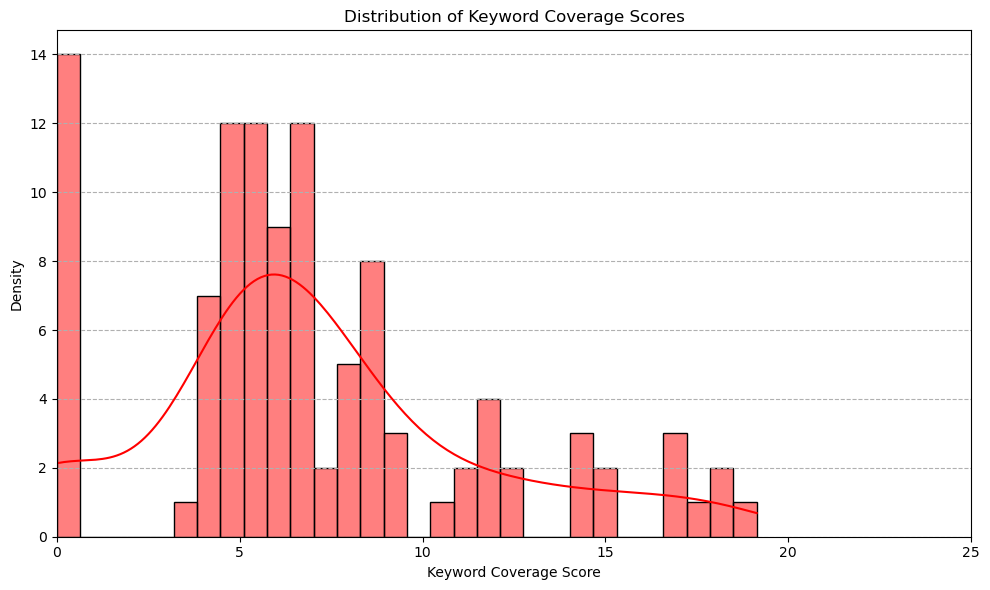

count    106.000000
mean       7.018374
std        4.548398
min        0.000000
25%        4.745508
50%        6.280316
75%        8.641144
max       19.135805
Name: score3d_keyword, dtype: float64

In [55]:

# plot the histogram of dim3_score.score3d_keyword
plt.figure(figsize=(10, 6))
sns.histplot(dim3_score['score3d_keyword'], bins=30, kde=True, color='red', stat='count')
plt.title('Distribution of Keyword Coverage Scores')
plt.xlabel('Keyword Coverage Score')
plt.ylabel('Density')
plt.xlim(0, 25)
plt.xticks(np.arange(0, 26, 5))
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('../../Data/processed/dim3_keyword_score_distribution.png')
plt.show()

# get the statistics of dim3_score.score3d_keyword
dim3_score['score3d_keyword'].describe()


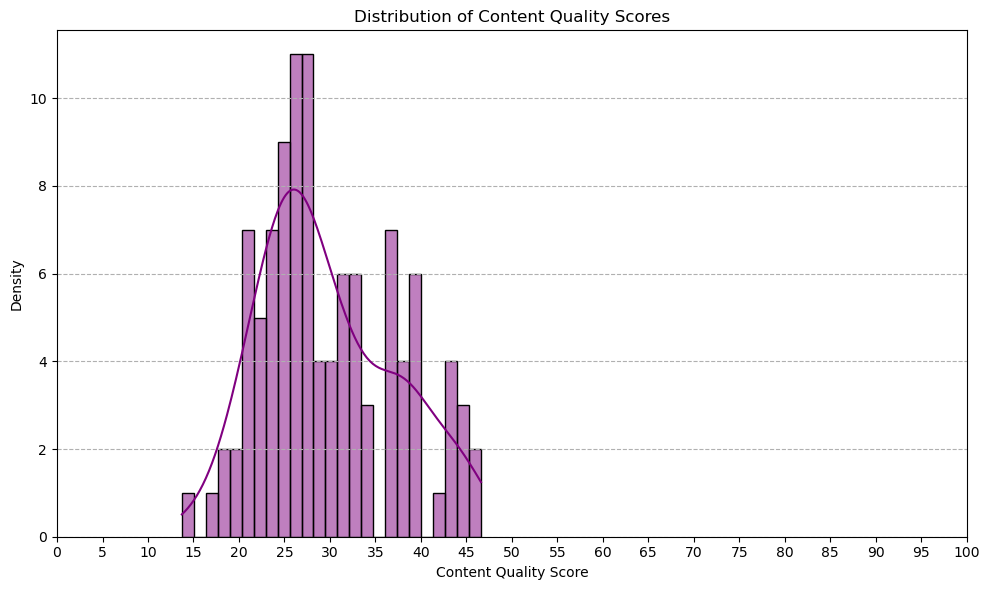

count    106.000000
mean      29.733987
std        7.397695
min       13.722210
25%       24.514034
50%       27.822528
75%       35.832504
max       46.609848
Name: score3_content_quality, dtype: float64

In [57]:
# update the dim3_score with the final scores as the sum of the four scores
dim3_score['score3_content_quality'] = dim3_score[['score3a_originality', 'score3b_vertical', 
                                                  'score3c_sentiment', 'score3d_keyword']].sum(axis=1)

# 绘制总分分布直方图
plt.figure(figsize=(10, 6))
sns.histplot(dim3_score['score3_content_quality'], bins=25, kde=True, color='purple', stat='count')
plt.title('Distribution of Content Quality Scores')
plt.xlabel('Content Quality Score')
plt.ylabel('Density')
plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 5))
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('../../Data/processed/dim3_content_quality_score_distribution.png')
plt.show()

# 获取总分的统计信息
dim3_score['score3_content_quality'].describe()

In [58]:
dim3_score

,user_id,score3a_originality,score3b_vertical,score3c_sentiment,score3d_keyword,score3_content_quality
0,576d3bde82ec3952ff40c5e1,8.432660,16.994900,0,17.310267,42.737827
1,58b325ce50c4b442ae017a30,14.998619,6.235195,0,6.420745,27.654559
2,5c0c067c0000000005022f0a,10.543248,2.949497,0,6.513708,20.006453
3,5649379603eb842b7ed00477,6.638673,18.076385,0,14.365441,39.080498
4,5d6a927e00000000010068b9,6.160470,17.994915,0,8.362067,32.517453
...,...,...,...,...,...,...
101,5a5bf1414eacab4087b808c7,12.659866,5.267211,0,5.947809,23.874886
102,621a0927000000001000f950,13.770318,4.379307,0,5.051478,23.201104
103,5c4be6f500000000100050c6,15.164123,4.329531,0,5.392471,24.886125
104,587623ba6a6a691cffba0875,19.052512,11.227645,0,8.116811,38.396968


In [ ]:




# =============================================
# 3. INDIVIDUAL SCORING FUNCTIONS
# =============================================








# =============================================
# 4. MAIN ORCHESTRATION FUNCTION
# =============================================

def calculate_all_scores(df, core_keywords):
    """主流程：计算所有内容分数"""
    print("1. 加载模型...")
    models = load_models()
    
    print("2. 预处理数据...")
    df, user_notes = preprocess_data(df)
    
    print("3. 计算原创性分数...")
    df = calculate_originality_score(df, models)
    
    print("4. 计算垂直领域分数...")
    df = calculate_vertical_score(df)
    
    print("5. 计算情感强度分数...")
    df = calculate_sentiment_score(df, models)
    
    print("6. 计算关键词覆盖分数...")
    df = calculate_keyword_count(df, core_keywords)
    df = calculate_single_keyword_score(df)
    df = calculate_user_keyword_score(df)
    
    print("所有分数计算完成!")
    return df

In [14]:
# 示例使用
df = pd.read_json('../../Data/processed/contents_cooked_semantic.json', lines=True)

# 定义核心关键词
CORE_KEYWORDS = {
    '鲜芋仙', 'Meet Fresh', 'MeetFresh', '台湾美食', '甜品',
    '芋圆', 'taro', '仙草', 'grass jelly', '奶茶', 'milk tea',
    '豆花', 'tofu pudding', '奶刨冰', 'milked shaved ice', 
    '红豆汤', 'purple rice soup', '紫米粥', 'red bean soup',
    '2001 Coit Rd', 'Park Pavillion Center', '(972) 596-6088',
    '刘一手', '锅底', '火锅',
}

# 计算所有分数
scored_df = calculate_all_scores(df, CORE_KEYWORDS)

# 查看结果
print(scored_df[['user_id', 'originality', 'vertical', 'sentiment', 'keyword']].head())

1. 加载模型...
2. 预处理数据...
3. 计算原创性分数...


Batches:   0%|          | 0/499 [00:00<?, ?it/s]

h:\Software\miniforge3\envs\torch\lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


4. 计算垂直领域分数...
5. 计算情感强度分数...
6. 计算关键词覆盖分数...
所有分数计算完成!
                    user_id   originality  vertical  sentiment    keyword
0  576d3bde82ec3952ff40c5e1 -5.551115e-15       0.0       25.0  13.714851
1  576d3bde82ec3952ff40c5e1  2.775558e-15       0.0       25.0  13.714851
2  576d3bde82ec3952ff40c5e1  0.000000e+00       0.0       25.0  13.714851
3  576d3bde82ec3952ff40c5e1 -2.980232e-06       0.0       25.0  13.714851
4  576d3bde82ec3952ff40c5e1 -2.980232e-06       0.0       25.0  13.714851


C:\Users\Han\AppData\Local\Temp\ipykernel_1228\3016393291.py:140: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_scores = df.groupby('user_id').apply(user_keyword_aggregation)


In [19]:
scored_df.originality.value_counts()

originality
 0.000000e+00    5811
-5.551115e-15    3421
-2.980232e-06    2715
-5.960464e-06    2087
 2.980232e-06     393
-1.110223e-14     332
-8.940697e-06     331
 5.960464e-06     216
-1.192093e-05     141
 1.490116e-06     129
 4.470348e-06     101
 2.775558e-15      66
 5.551115e-15      47
 8.940697e-06      46
 7.450581e-06      34
 8.326673e-15      22
 1.043081e-05      16
-1.665335e-14      10
 1.192093e-05       9
-1.490116e-05       5
 1.387779e-14       2
 1.665335e-14       2
 1.110223e-14       2
 1.490116e-05       2
 1.341105e-05       1
Name: count, dtype: int64

In [20]:
scored_df.vertical.value_counts()

vertical
0.0     15213
5.0       633
10.0       91
15.0        4
Name: count, dtype: int64

In [17]:
scored_df.sentiment.value_counts()

sentiment
25.000000    14347
0.000000       353
9.295962         2
2.022227         1
12.356882        1
             ...  
0.915073         1
0.854627         1
0.579986         1
0.831711         1
0.000066         1
Name: count, Length: 1242, dtype: int64

In [18]:
scored_df.keyword.value_counts()

keyword
5.318313     781
6.726553     737
8.741024     600
6.084625     560
6.085666     510
            ... 
16.671688     21
16.424657     15
13.452744     14
15.691151     14
7.374754      11
Name: count, Length: 105, dtype: int64

In [ ]:
# class ContentScorer:
#     def __init__(self, df):
#         self.df = df.copy()
#         self.users = df['user_id'].unique()
#         self._prepare_models()
        
#     def _prepare_models(self):
#         """预加载所有模型"""
#         # 原创性检测模型
#         self.tfidf = TfidfVectorizer(max_features=6000)
#         self.simcse = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
        
#         # 情感分析模型
#         self.bert_tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
#         self.bert_model = BertModel.from_pretrained("bert-base-chinese")
#         self.bert_model.eval()
        
#     def calculate_all_scores(self):
#         """主流程：计算所有分数"""
#         # 预处理
#         self._preprocess()
        
#         # 计算各维度分数
#         self._calc_originality()
#         self._calc_vertical()
#         self._calc_sentiment()
#         self._calc_keyword()
        
#         return self.df
    
#     def _preprocess(self):
#         """数据预处理"""
#         # 转换时间格式
#         self.df['elapsed_days'] = self.df['elapsed_time']
        
#         # 构建用户笔记映射
#         self.user_notes = self.df.groupby('user_id')['semantic_proc_text'].apply(list)
        
#     # ======================
#     # 1. 文本原创性计算（用户维度）
#     # ======================
#     def _calc_originality(self):
#         """原创性评分"""
#         all_texts = self.df['semantic_proc_text'].tolist()
        
#         # TF-IDF相似度
#         tfidf_matrix = self.tfidf.fit_transform(all_texts)
#         tfidf_sim = cosine_similarity(tfidf_matrix)
        
#         # SimCSE相似度
#         embeddings = self.simcse.encode(all_texts, show_progress_bar=True)
#         simcse_sim = cosine_similarity(embeddings)
        
#         # 取最大值并计算得分
#         max_sim = np.maximum(tfidf_sim.max(axis=1), simcse_sim.max(axis=1))
#         self.df['originality'] = (1 - max_sim) * 25
        
#     # ======================
#     # 2. 垂直领域分布（使用tag_list）
#     # ======================
#     def _calc_vertical(self):
#         """垂直领域评分"""
#         target_tags = {'美食', '探店', '餐饮', '餐厅', '美食探店'}
        
#         def _calc_similarity(tags):
#             user_tags = set(tags.split(','))
#             intersection = user_tags & target_tags
#             return len(intersection) / len(target_tags) if target_tags else 0
        
#         self.df['vertical'] = self.df['tag_list'].apply(
#             lambda x: min(_calc_similarity(x)*25, 25)
#         )
        
#     # ======================
#     # 3. 情感强度计算
#     # ======================
#     def _calc_sentiment(self):
#         """情感评分"""
#         # 时间衰减系数
#         decay = np.exp(-0.05 * self.df['elapsed_days'] / 7)
        
#         # 情感值计算
#         self.df['sentiment'] = self.df['semantic_proc_text'].apply(
#             lambda x: self._get_bert_sentiment(x)
#         ) * decay
        
#         # 标准化
#         p90 = self.df['sentiment'].quantile(0.9)
#         self.df['sentiment'] = (self.df['sentiment'] / p90 * 25).clip(0, 25)
        
#     def _get_bert_sentiment(self, text):
#         """BERT情感分析"""
#         inputs = self.bert_tokenizer(text[:512], return_tensors="pt", truncation=True)
#         with torch.no_grad():
#             outputs = self.bert_model(**inputs)
#         return outputs.last_hidden_state.mean().item()
    
#     # ======================
#     # 4. 关键词覆盖
#     # ======================
#     def _calc_keyword(self):
#         """关键词评分"""
#         # 时间衰减
#         decay = np.exp(-0.05 * self.df['elapsed_days'] / 7)
        
#         # 关键词计数
#         pattern = re.compile('|'.join(re.escape(kw) for kw in CORE_KEYWORDS), flags=re.IGNORECASE)
#         self.df['kw_count'] = self.df['semantic_proc_text'].apply(
#             lambda x: len(pattern.findall(x))
#         )
        
#         # 单篇得分
#         single_score = np.maximum(1, self.df['kw_count'] / 5) * decay
        
#         # 用户级计算
#         user_scores = self.df.groupby('user_id').apply(self._user_keyword_score)
#         self.df = self.df.merge(user_scores, on='user_id')
        
#     def _user_keyword_score(self, group):
#         """用户维度关键词计算"""
#         # 基准值计算
#         p90 = group['single_score'].quantile(0.9)
#         cover_rate = (group['kw_count'] > 0).mean()
        
#         # 综合得分
#         score = (group['single_score'].mean() / p90 * 0.7 + cover_rate / 0.5 * 0.3) * 25
#         return pd.Series({'keyword': score.clip(0, 25)})